# Lagrangian Simulation of Marine Debris Movement

This Jupyter notebook is designed to model and simulate the movement of marine debris around the coast of Malta, using the OceanParcels framework. The process involves a series of steps starting with importing necessary libraries, preparing datasets, and setting up the simulation environment, followed by initializing particle positions, defining custom behavior through kernels, executing the simulation, and finally visualizing the results.

The objective is to understand how marine debris, represented by particles in the simulation, moves under the influence of ocean currents and wind. This notebook aims to provide insights into the dispersion patterns of debris in marine environments, which is critical for environmental studies and conservation efforts.

### Importing Necessary Libraries

In [1]:
from parcels import (
    AdvectionRK4,
    Field,
    FieldSet,
    JITParticle,
    ParticleSet,
    StatusCode,
    Variable,
)
import parcels.rng as ParcelsRandom
from datetime import timedelta
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.features import rasterize
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

### Suppress Future Warnings

In [2]:
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Verifying the structure and dimentions of the data files

Before proceeding with the simulation, it's crucial to inspect the structure and dimensions of the datasets involved. This section opens and prints the metadata of the Sea Surface Current (SSC) and the Wind datasets, providing an understanding of their structure, variables, and dimensions. It ensures that the datasets are correctly formatted and suitable for use in the simulation.

In [3]:
# Open the SSC dataset
ssc_ds = xr.open_dataset("Data/model_IO/7_day_SSC_Data.nc")

# Print the SSC dataset information
print("SSC Dataset:\n")
print(ssc_ds)
print("=" * 175)

# Close datasets after inspection
ssc_ds.close()

SSC Dataset:

<xarray.Dataset> Size: 21MB
Dimensions:  (time: 168, lat: 52, lon: 43)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2023-01-01 ... 2023-01-07T23:00:00
  * lat      (lat) float32 208B 35.74 35.77 35.79 35.81 ... 36.84 36.86 36.88
  * lon      (lon) float32 172B 13.68 13.72 13.76 13.8 ... 15.3 15.34 15.38
Data variables:
    u        (time, lat, lon) float64 3MB ...
    v        (time, lat, lon) float64 3MB ...
    stdu     (time, lat, lon) float64 3MB ...
    stdv     (time, lat, lon) float64 3MB ...
    cov      (time, lat, lon) float64 3MB ...
    velo     (time, lat, lon) float64 3MB ...
    head     (time, lat, lon) float64 3MB ...
Attributes: (12/17)
    NC_GLOBAL.Title:                   Near-Real time Surface Ocean Velocity
    NC_GLOBAL.origin:                  MRAG (measured);LICA (measured);SOPU (...
    NC_GLOBAL.source:                  HF Radar Derived Surface Currents obta...
    NC_GLOBAL.history:                 08-Jun-2023 19:17:47
    NC_GLOBAL.gri

### Loading shapefile and extracting coastline boundaries

The coastline boundaries are essential for defining the simulation area and implementing land-sea interactions. This section loads a shapefile representing Malta's coastline and visualizes the coastline. This shapefile is crucial for the creation of the land sea mask in the next step.

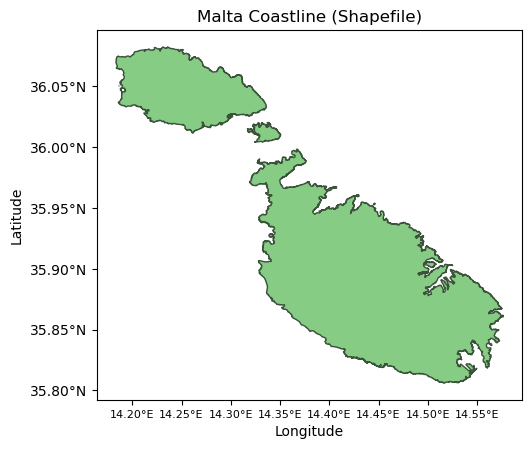

In [4]:
# Load the shapefile
shapefile_path = 'Data/land_sea_mask/MaltaCoastline.shp'
gdf = gpd.read_file(shapefile_path)

# Convert the GeoDataFrame to WGS 84 CRS (if it's not already)
gdf = gdf.to_crs(epsg=4326)

# Plot the shapefile with latitude and longitude labels
gdf.plot(color='#86CC85', edgecolor='#3B533B')
plt.title('Malta Coastline (Shapefile)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Format the axis labels to show degrees
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.2f}°E'.format(val)))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.2f}°N'.format(val)))

# Make the x-axis labels smaller
plt.gca().tick_params(axis='x', labelsize=8)  

# Display the plot
plt.show()

### Createing the Land-Sea Mask

A high-resolution land-sea mask is generated by rasterizing the coastline shapefile. This mask distinguishes between land and sea areas, allowing for accurate particle tracking near coastal regions. The mask is saved as a NetCDF file and visualized to verify its correctness. This preparation is vital for the simulation, as it influences particle behavior at the land-sea interface.

The visualization displays the land-sea mask with dark purple indicating sea areas (0) and red with a white outline denoting land areas (1).

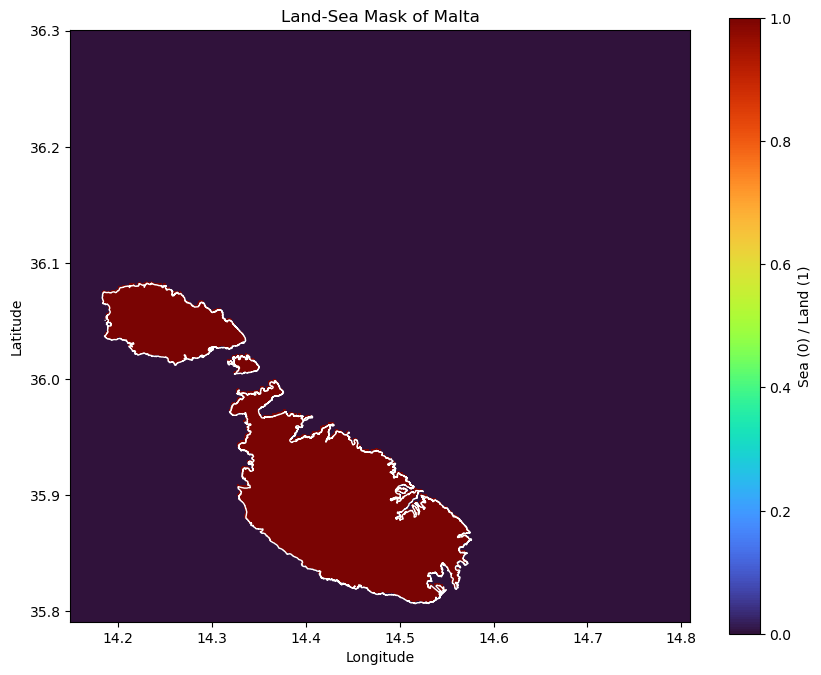

In [5]:
# Convert GeoDataFrame projection to WGS 84 for compatibility
gdf = gdf.to_crs(epsg=4326)

# Define the geographical bounds for the simulation area
lon_min, lat_min, lon_max, lat_max = 14.15, 35.79, 14.81, 36.3

# Set the resolution of the grid in kilometers (0.1 km)
resolution_km = 0.1 

# Calculate the resolution in degrees based on the latitude
mean_lat = (lat_min + lat_max) / 2  # Average latitude for the area
km_per_degree = np.cos(mean_lat * np.pi / 180) * 111.32  # Approx. kilometers per degree at this latitude
resolution_degrees = resolution_km / km_per_degree  # Convert resolution from km to degrees

# Determine the number of grid cells needed based on the area's dimensions and resolution
num_lons = int(np.ceil((lon_max - lon_min) / resolution_degrees))  # Number of longitude cells
num_lats = int(np.ceil((lat_max - lat_min) / resolution_degrees))  # Number of latitude cells

# Generate transformation parameters for converting lat/lon to grid coordinates
transform = rasterio.transform.from_origin(lon_min, lat_max, resolution_degrees, resolution_degrees)

# Convert the shapefile to a raster format using the specified grid resolution
raster = rasterize(
    [(geom, 1) for geom in gdf.geometry],  # Assign a value of 1 to all shapes
    out_shape=(num_lats, num_lons),  # Shape of the output raster
    transform=transform,  # Transformation parameters
    fill=0,  # Fill value outside shapes (representing sea)
    all_touched=True  # Include all pixels touched by geometries
)

# Generate arrays of longitude and latitude values corresponding to the grid
lons = np.linspace(lon_min, lon_max, num_lons, endpoint=False)  # Longitude values
lats = np.linspace(lat_max, lat_min, num_lats, endpoint=False)[::-1]  # Latitude values (reversed)

# Create an xarray Dataset with the land-sea mask, using the generated raster grid
ds = xr.Dataset(
    {
        'land_sea_mask': (['lat', 'lon'], raster)  # Define the land-sea mask variable
    },
    coords={
        'lon': lons,  # Longitude coordinate
        'lat': lats   # Latitude coordinate
    }
)

# Save the land-sea mask dataset as a NetCDF file
nc_filename = "Data/land_sea_mask/land_sea_mask_malta.nc"
ds.to_netcdf(nc_filename)

# Plot the generated land-sea mask to visually verify its accuracy
plt.figure(figsize=(10, 8))
plt.pcolormesh(lons, lats[::-1], raster, cmap='turbo')  
# Colorbar for differentiation
plt.colorbar(label='Sea (0) / Land (1)')  
plt.title('Land-Sea Mask of Malta')  
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  

# Overlay the original shapefile on the raster to check alignment
gdf.plot(ax=plt.gca(), color='none', edgecolor='white')

# Display the plot
plt.show()  

### Creating a FieldSet

A `FieldSet` is created from the sea surface current and wind datasets. It serves as the simulation environment, defining the velocity fields that drive particle movement. The land-sea mask is also incorporated into the FieldSet as an additional field, providing the necessary data for reflecting or deleting particles upon reaching the coastline.

In [6]:
# Create a fieldset
fieldset = FieldSet.from_netcdf(
    filenames={
        "U": "Data/model_IO/7_day_SSC_Data.nc",  # Path to NetCDF file for ocean surface currents (U component)
        "V": "Data/model_IO/7_day_SSC_Data.nc",  # Path to NetCDF file for ocean surface currents (V component)
    },
    variables={
        "U": "u",  # Variable name in the file for U component of ocean surface currents
        "V": "v",  # Variable name in the file for V component of ocean surface currents
    },
    dimensions={
        "U": {"lon": "lon", "lat": "lat", "time": "time"},  # Dimensions for U (ocean currents)
        "V": {"lon": "lon", "lat": "lat", "time": "time"},  # Dimensions for V (ocean currents)
    },
    # Allow the model to extrapolate values beyond the dataset's time range
    allow_time_extrapolation=True  
)

# Load the land-sea mask data from a NetCDF file
landsea_data = xr.open_dataset("Data/land_sea_mask/land_sea_mask_malta.nc")

# Add the land-sea mask as a Field to the FieldSet, enabling land-sea differentiation in the simulation
fieldset.add_field(Field('land_sea_mask', 
                         data=landsea_data['land_sea_mask'].values,
                         lon=landsea_data['lon'].values,  
                         lat=landsea_data['lat'].values,  
                         mesh='spherical',
                         interp_method='nearest'))  

### Initializing the Particles

Particles are initialized near a specified location with random offsets to simulate a dispersed release. The section also plots the initial positions of these particles on the map, to show where they will be initialised exactly. The particles represent the objects of interest, such as sea surface debris, whose movements are to be simulated.

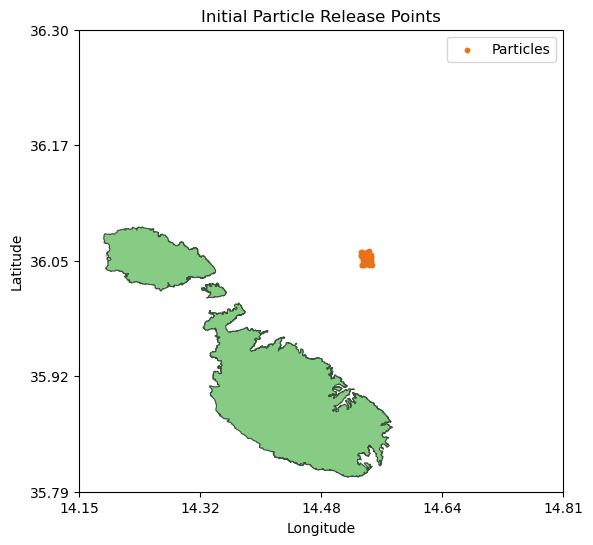

In [7]:
# Number of particles to simulate
num_particles = 50

# Geographic coordinates for the starting point of all particles
start_lat = 36.0475
start_lon = 14.5417

# Range for generating random offsets for the particles
offset_range = 0.008  

# Generate random offsets for longitude and latitude to simulate initial dispersion
lon_offsets = np.random.uniform(-offset_range, offset_range, num_particles)
lat_offsets = np.random.uniform(-offset_range, offset_range, num_particles)

# Apply these offsets to the starting point to get initial positions
lon_release = start_lon + lon_offsets
lat_release = start_lat + lat_offsets

# Define the geographic boundaries for plotting
extent = [14.15, 14.81, 35.79, 36.3]

# Prepare the plot with a geographic (Plate Carree) projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)

# Plot the coastline of Malta from a shapefile using GeoPandas
gdf.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=2)

# Plot the initial positions of the particles on the map
scatter = ax.scatter(lon_release, lat_release, s=10, c="#e8721a", marker='o', transform=ccrs.PlateCarree(), label='Particles')

# Define and set ticks for longitude and latitude to improve map readability
lon_ticks = np.linspace(extent[0], extent[1], num=5) 
lat_ticks = np.linspace(extent[2], extent[3], num=5) 
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.set_xticklabels([f'{tick:.2f}' for tick in lon_ticks])
ax.set_yticklabels([f'{tick:.2f}' for tick in lat_ticks])

# Add additional plot elements 
plt.title("Initial Particle Release Points")
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.legend()  

# Display the plot
plt.show()  

### Define Simulation Parameters

This brief section specifies the simulation's runtime and timestep. These parameters determine the duration of the simulation and the frequency at which the particles' positions are updated.

In [8]:
# Define the total duration of the simulation
runtime = timedelta(days=7)  

# Set the time step for the simulation
dt = timedelta(minutes=60) 

### Custom kernels & executing the simulation

Custom kernels are defined to implement specific behaviors during the simulation, such as checking for out-of-bounds conditions and reflecting particles at the coastline. The simulation is then executed with these kernels, and the output is saved for subsequent visualization. This step combines the prepared environment, particle initialization, and custom behaviors to simulate the Lagrangian particle movement.

In [9]:
# Custom Kernel to delete particles that move out of bounds
def CheckOutOfBounds(particle, fieldset, time):
    # Check if particle state indicates an out-of-bounds error
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()  # Remove the particle from the simulation

# Custom Kernel to delete particles encountering any error state
def CheckError(particle, fieldset, time):
    # Captures all errors with state codes greater than or equal to 50
    if particle.state >= 50:  
        particle.delete()  # Remove the particle from the simulation
        
# Custom particle class with added variables for previous positions and elapsed time
class ReflectiveParticle(JITParticle):
    # Previous longitude, initialized to the first longitude of the field
    prev_lon = Variable('prev_lon', initial=fieldset.U.grid.lon[0])  
    # Previous latitude, initialized to the first latitude of the field
    prev_lat = Variable('prev_lat', initial=fieldset.U.grid.lat[0])  
    # Elapsed time since the start of the simulation in days
    elapsed_time = Variable('elapsed_time', initial=0.)  
    
# Custom Kernel to update the elapsed time of particles
def UpdateElapsedTime(particle, fieldset, time):
    # Increment elapsed_time by the absolute value of particle's dt, converted from seconds to days
    particle.elapsed_time += math.fabs(particle.dt) / (3600 * 24)
    
# Custom Kernel to update particle's previous position before it moves
def UpdatePreviousPosition(particle, fieldset, time):
    # Store current position as previous position for reflection logic
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat
    
# Kernel to reflect particles upon hitting land
def ReflectOnLand(particle, fieldset, time):
    # Check if particle is on land using the land-sea mask
    if fieldset.land_sea_mask[particle] == 1:
        # Generate a random number to decide on beaching or reflection
        random_number = ParcelsRandom.random()
        beaching_probability = 0.15  # 15% chance to be beach

        if random_number <= beaching_probability:
            # Delete the particle if it beaches
            particle.delete()
        else:
            # Reflect the particle by reverting to its previous position
            particle.lon = particle.prev_lon
            particle.lat = particle.prev_lat

# Initialize a ParticleSet with particles using the ReflectiveParticle class
pset = ParticleSet(fieldset=fieldset, pclass=ReflectiveParticle, lon=lon_release, lat=lat_release)

# Define output file for the simulation data (particle data is saved every 30 minutes)
output_file = pset.ParticleFile(name="Lagrangian_Output/7_day_simulation.zarr", outputdt=timedelta(minutes=60))

# Execute the simulation with the defined kernels and simulation parameters
pset.execute(
    AdvectionRK4 +  # Advection kernel using 4th order Runge-Kutta method
    pset.Kernel(UpdatePreviousPosition) +  # Custom kernel to update previous positions
    pset.Kernel(ReflectOnLand) +  # Custom kernel to handle reflection or beaching on land
    pset.Kernel(UpdateElapsedTime) +  # Custom kernel to update elapsed time
    pset.Kernel(CheckOutOfBounds) +  # Custom kernel to check for and handle out-of-bounds particles
    pset.Kernel(CheckError),  # Custom kernel to check for and handle errors
    runtime=runtime,  # Duration of the simulation
    dt=dt,  # Time step for the simulation
    output_file=output_file,  # Output file for storing particle data
)  

# Print a separator line after the simulation completes
print("="*175)

INFO: Output files are stored in Lagrangian_Output/7_day_simulation.zarr.
 16%|█▌        | 97200.0/604800.0 [00:06<00:32, 15565.80it/s]

### Visualising the particle dispertion

The output of the simulation is visualized to assess the movement and dispersion of particles over time. This visualization provides insights into the particles' trajectories and how they interact with the environment, particularly in response to ocean currents and wind. This is saved as a GIF file, providing a dynamic and accessible way to observe the simulated dispersion over time.

In [ ]:
# Load the simulation output from a Zarr dataset
ds = xr.open_zarr("Lagrangian_Output/7_day_simulation.zarr")

# Load and reproject the shapefile containing Malta's coastline to WGS 84
malta_map = gpd.read_file('Data/land_sea_mask/MaltaCoastline.shp')
malta_map = malta_map.to_crs(epsg=4326)

# Define the geographic boundaries for the plot, slightly zoomed in
extent = [14.15, 14.71, 35.79, 36.2]

# Disable interactive plotting to facilitate animation creation
plt.ioff()

# Initialize the plot with a specific size and PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent(extent)

# Plot Malta's map with specified colors and border lines
malta_map.plot(ax=ax, color='#86CC85', edgecolor='#3B533B', linewidth=0.8, zorder=2)

# Enhance the map with borders for context
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set custom tick labels for longitude and latitude without displaying degrees
lon_ticks = np.linspace(extent[0], extent[1], 5)
lat_ticks = np.linspace(extent[2], extent[3], 5)
ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax.set_xticklabels([f"{lon:.2f}" for lon in lon_ticks])
ax.set_yticklabels([f"{lat:.2f}" for lat in lat_ticks])

# Add labels to the axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Initialize an empty scatter plot for displaying particles
scatter = ax.scatter([], [], s=1, c="#E8721A", marker='o', transform=ccrs.PlateCarree(), label='Particles')

# Add a legend to the plot to identify the particles
ax.legend(loc='upper right')

# Initialize a text element to display the simulation day
simulation_start_date = pd.to_datetime('2023-01-01')
day_text = fig.text(0.5, 0.95, '', ha='center', va='center', fontsize='large', color='black')

# Define a function to update the scatter plot and day counter for each frame
def update(frame):
    # Extract data for the current time step
    time_step_data = ds.isel(obs=frame)
    scatter.set_offsets(np.vstack((time_step_data.lon.values, time_step_data.lat.values)).T)
    
    # Update the day counter based on the current time step
    current_time_str = time_step_data.time.values[0]
    current_time = pd.to_datetime(current_time_str)
    num_days = (current_time - simulation_start_date).days + 1
    day_text.set_text(f"Day: {num_days}")

    return scatter, day_text

# Determine the total number of days (frames) for the animation
total_days = ds.sizes['obs']

# Create the animation using the FuncAnimation class
ani = FuncAnimation(fig, update, frames=total_days, interval=100, blit=False)

# Set a limit for the animation size
mpl.rcParams['animation.embed_limit'] = 300

# Save the animation as a GIF
ani.save('Lagrangian_Output/7_day_simulation.gif', writer='pillow')

### Animation of the particle movement

Finally, an animation is created to dynamically represent the particles' trajectories over the simulation period. This visualization offers an engaging way to observe and understand the simulated movements of marine debris or other particles within the marine environment.

In [ ]:
# Print statement before the animation
print("Animation of particle trajectories over time:\n")

# Display the animation
HTML(ani.to_jshtml())

---